In [ ]:
# 라이브러리 import 및 TensorFlow 버전 확인

import tensorflow as tf
import numpy as np
import pandas as pd

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.19.0


In [ ]:
# 데이터 다운로드
path_to_train_file = tf.keras.utils.get_file(
    'train.txt',
    'https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt'
)
path_to_test_file = tf.keras.utils.get_file(
    'test.txt',
    'https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt'
)


14628807/14628807 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4893335/4893335 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
#  텍스트로 로드
train_text = open(path_to_train_file, 'rb').read().decode(encoding='utf-8')
test_text = open(path_to_test_file, 'rb').read().decode(encoding='utf-8')

print('Length of train text: {} characters'.format(len(train_text)))
print('Length of test text: {} characters'.format(len(test_text)))
print(train_text[:300]) #처음 300자만 데이터가 제대로 로드되었는지 확인

Length of train text: 6937271 characters
Length of test text: 2318260 characters
id	document	label
9976970	아 더빙.. 진짜 짜증나네요 목소리	0
3819312	흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나	1
10265843	너무재밓었다그래서보는것을추천한다	0
9045019	교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정	0
6483659	사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 던스트가 너무나도 이뻐보였다	1
5403919	막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.	0
7797314	원작의


In [ ]:
# Y(정답 라벨) 데이터 만들기
train_Y = np.array([
    [int(row.split('\t')[2])]
    for row in train_text.split('\n')[1:]
    if row.count('\t') > 0
])

test_Y = np.array([
    [int(row.split('\t')[2])]
    for row in test_text.split('\n')[1:]
    if row.count('\t') > 0
])

print("train_Y shape:", train_Y.shape)
print("test_Y shape:", test_Y.shape)
print("train_Y sample:", train_Y[:5])

train_Y shape: (150000, 1)
test_Y shape: (50000, 1)
train_Y sample: [[0]
 [1]
 [0]
 [0]
 [1]]


In [ ]:
# 문장 부분만 추출 (정제 과정 제거)
train_text_X = [
    row.split('\t')[1]
    for row in train_text.split('\n')[1:]
    if row.count('\t') > 0
]

test_text_X = [
    row.split('\t')[1]
    for row in test_text.split('\n')[1:]
    if row.count('\t') > 0
]

print(train_text_X[:5])

['아 더빙.. 진짜 짜증나네요 목소리', '흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나', '너무재밓었다그래서보는것을추천한다', '교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정', '사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 던스트가 너무나도 이뻐보였다']


In [ ]:
VOCAB_SIZE = 2000   # 단어 사전 크기
MAX_LEN = 25        # 최대 문장 길이 (패딩 기준)

vectorize_layer = tf.keras.layers.TextVectorization(
    standardize='lower_and_strip_punctuation',  # 소문자 변환 + 구두점 제거
    split='whitespace',                         # 띄어쓰기 기준 토큰화
    max_tokens=VOCAB_SIZE,                      # 단어 사전 크기
    output_mode='int',                          # 정수 인코딩
    output_sequence_length=MAX_LEN              # 자동 패딩
)

vectorize_layer.adapt(train_text_X)
# 텍스트를 정수 시퀀스로 변환 (패딩 포함)
train_X = vectorize_layer(train_text_X)

print(train_X[:5])

tf.Tensor(
[[  37  914    5    1 1077    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]
 [   1    1    1    1    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]
 [   1    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]
 [   1    1   75  353    1    1    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]
 [   1    1  103    1    1    1  800    1    1  544    1    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]], shape=(5, 25), dtype=int64)


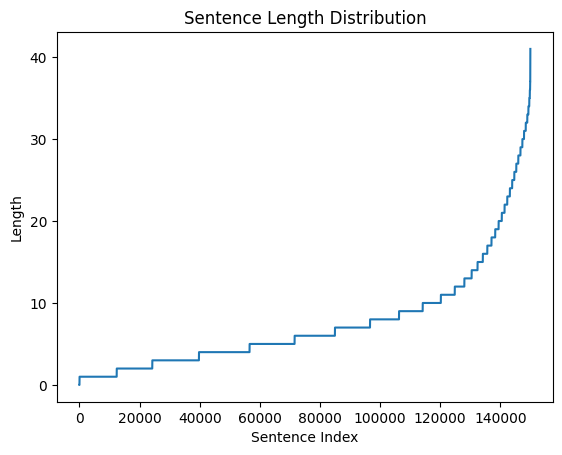

144646


In [ ]:
import matplotlib.pyplot as plt
sentence_len = [len(sentence.split()) for sentence in train_text_X]
sentence_len.sort()
plt.plot(sentence_len)
plt.title("Sentence Length Distribution")
plt.xlabel("Sentence Index")
plt.ylabel("Length")
plt.show()

print(sum([int(l<=25) for l in sentence_len]))

In [ ]:
# 모델의 주요 설정값들을 미리 정의해줍니다.
VOCAB_SIZE = 2000    # 단어 사전 크기 (가장 많이 등장하는 2000개의 단어만 사용)
EMBEDDING_DIM = 128  # 각 단어를 128차원 벡터로 표현
MAX_LEN = 25         # 모든 문장의 길이를 25단어로 통일 (패딩 기준)
EPOCHS = 10          # 전체 데이터를 몇 번 반복 학습할지
BATCH_SIZE = 32      # 한 번에 학습할 데이터 묶음 크기

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_LEN),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(
    train_X, train_Y,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    verbose=1
)

Epoch 1/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 24s 6ms/step - accuracy: 0.6670 - loss: 0.5716 - val_accuracy: 0.7459 - val_loss: 0.4771
Epoch 2/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 41s 6ms/step - accuracy: 0.7404 - loss: 0.4793 - val_accuracy: 0.7502 - val_loss: 0.4682
Epoch 3/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - accuracy: 0.7450 - loss: 0.4695 - val_accuracy: 0.7510 - val_loss: 0.4675
Epoch 4/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - accuracy: 0.7450 - loss: 0.4649 - val_accuracy: 0.7518 - val_loss: 0.4683
Epoch 5/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 40s 5ms/step - accuracy: 0.7490 - loss: 0.4596 - val_accuracy: 0.7463 - val_loss: 0.4732
Epoch 6/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - accuracy: 0.7503 - loss: 0.4565 - val_accuracy: 0.7485 - val_loss: 0.4699
Epoch 7/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - accuracy: 0.7504 - loss: 0.4547 - val_accuracy: 0.7531 - val_loss: 0.4699
Epoch 8/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - accuracy: 0.7531 - loss: 0

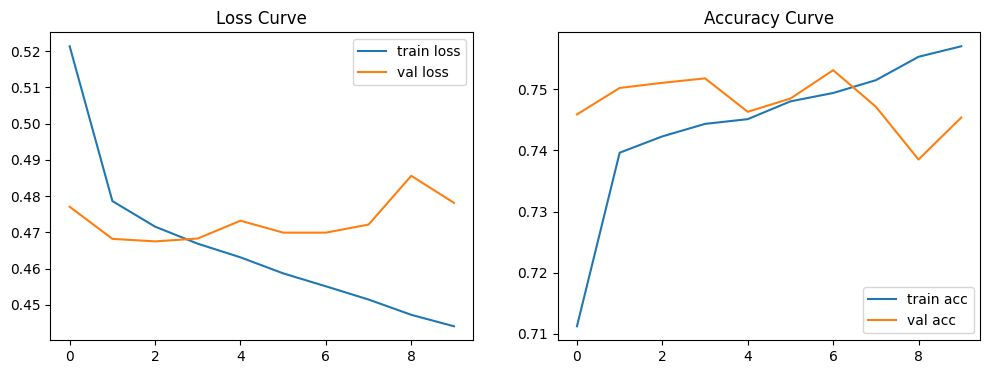

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend(); plt.title('Loss Curve')

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend(); plt.title('Accuracy Curve')
plt.show()

In [ ]:
test_loss, test_acc = model.evaluate(test_X, test_Y, verbose=0)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

NameError: name 'test_X' is not defined

In [ ]:
example_sentences = [
    "이 영화 진짜 재미있어요",
    "완전 지루하고 별로였음",
    "배우 연기는 좋았지만 스토리가 아쉬웠다"
]

example_seq = vectorize_layer(example_sentences)
pred = model.predict(example_seq)

for s, p in zip(example_sentences, pred):
    print(f"문장: {s}")
    print(f"긍정 확률: {p[0]:.4f}")
    print("결과:", "긍정 😊" if p[0] > 0.5 else "부정 😞")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
문장: 이 영화 진짜 재미있어요
긍정 확률: 0.9932
결과: 긍정 😊
문장: 완전 지루하고 별로였음
긍정 확률: 0.0166
결과: 부정 😞
문장: 배우 연기는 좋았지만 스토리가 아쉬웠다
긍정 확률: 0.0173
결과: 부정 😞
